In [1]:
import numpy as np
import torch
from torch import nn
import csv
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from utils import get_rho_from_u, plot_3d, get_rho_network_from_u, train_rho_network_n_step
from model import Critic, RhoNetwork

In [2]:
n_cell = 8
T_terminal = 1
data = pd.read_csv('data_rho_8.csv')
rho = np.array(data.iloc[:, 1:len(data.iloc[0, :])])
d = rho[:, 0]

In [3]:
delta_T = 1 / n_cell
T = int(T_terminal / delta_T)
u_hist = [0.9 * np.ones((n_cell, T))]
rho_hist = [get_rho_from_u(u_hist[0], d)]
u_diff_hist, rho_diff_hist = list(), list()

u = 0.5 * np.ones((n_cell, T))
V = np.zeros((n_cell + 1, T + 1), dtype=np.float64)
rho = get_rho_from_u(u, d)

rho_network = RhoNetwork(2)
rho_optimizer = torch.optim.Adam(rho_network.parameters(), lr=1e-3)
rho_network = train_rho_network_n_step(n_cell, T_terminal, rho, rho_network, rho_optimizer, n_iterations=1)

fake_critic = Critic(2) #train_critic_fake(n_cell, T_terminal, np.zeros((n_cell + 1, T + 1)))
critic = Critic(2)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)

/Users/ninolau/Documents/GitHub/speed_control/utils.py:126: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/Users/ninolau/Documents/GitHub/speed_control/utils.py:126: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/Users/ninolau/Documents/GitHub/speed_

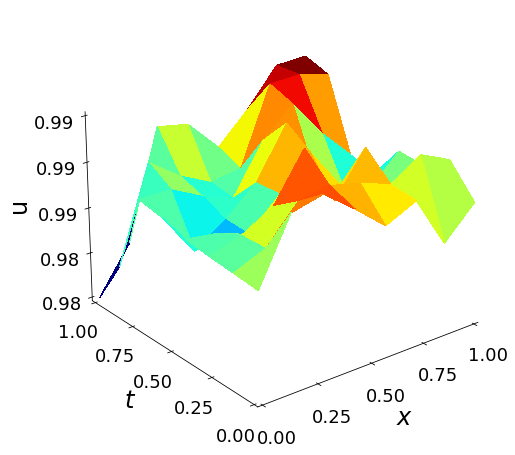

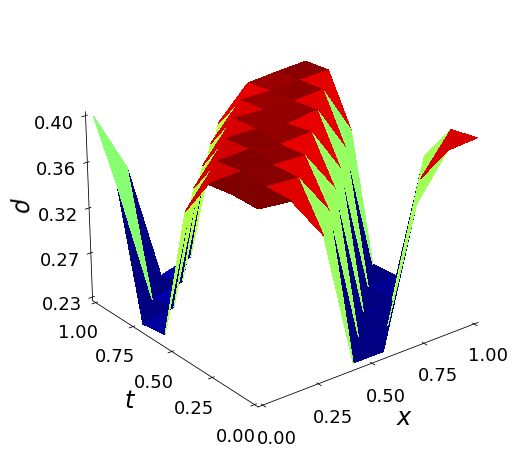

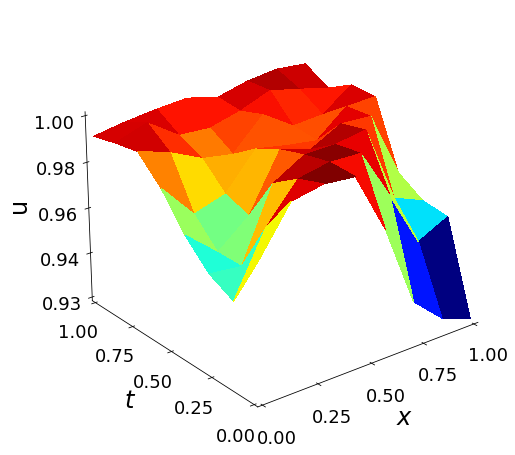

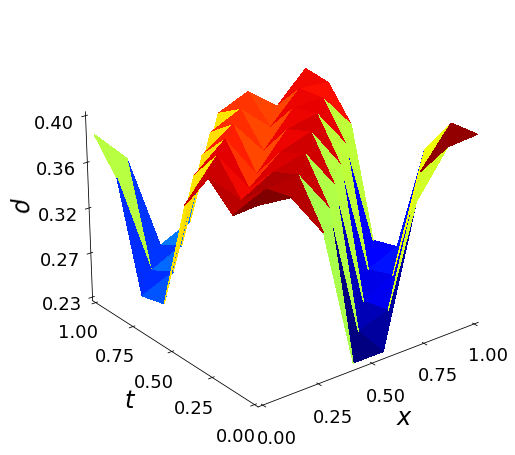

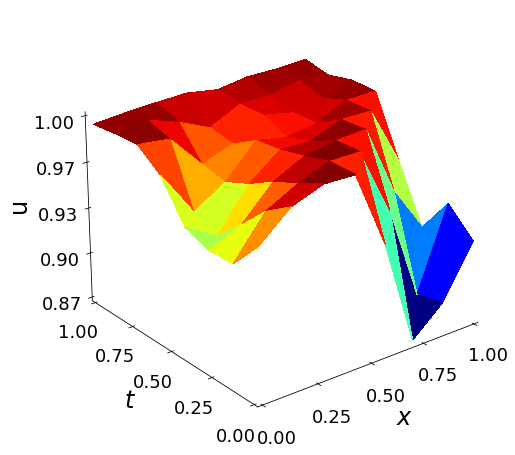

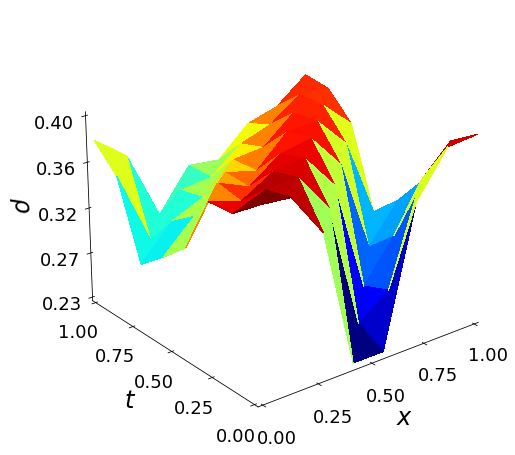

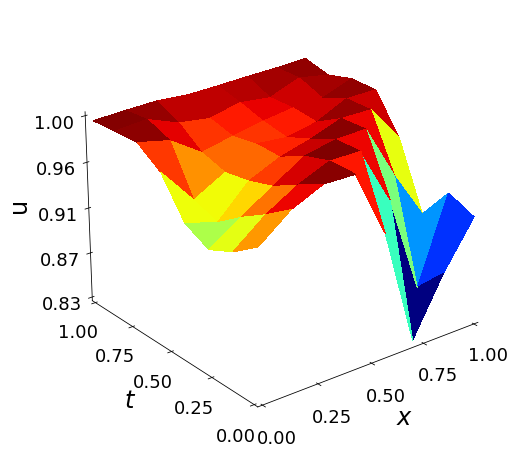

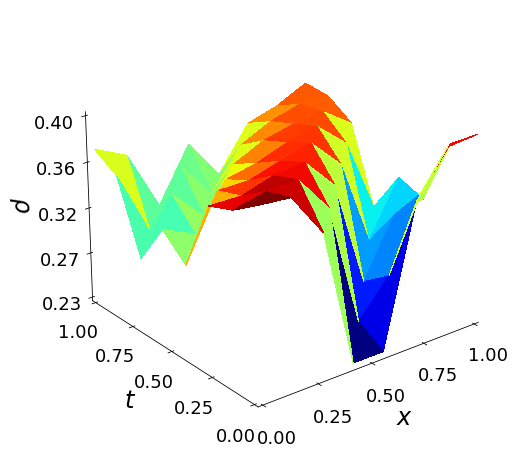

In [4]:
for it in range(100):
    states = list()
    truths = list()
    u = np.ones((n_cell, T))
    for i in range(n_cell + 1):
        for t in range(T + 1):
            states.append(np.array([i, t]) / n_cell)
            if t == T:
                truths.append(0)
            else:
                if i == n_cell:
                    rho_i_t = float(rho_network.forward(np.array([0, t]) / n_cell))
                    speed = min(max(float(critic(np.array([i, t + 1]) / n_cell) - critic(np.array([0, t + 1]) / n_cell)) / delta_T + 1,0),1) #- rho_i_t
                    truths.append(delta_T * (0.5 * speed ** 2 + rho_i_t  - speed) + fake_critic(
                        np.array([speed, t + 1]) / n_cell))
                else:
                    rho_i_t = float(rho_network.forward(np.array([i, t]) / n_cell))
                    speed = min(max(float(critic(np.array([i, t + 1]) / n_cell) - critic(np.array([i + 1, t + 1]) / n_cell)) / delta_T + 1,0),1) #- rho_i_t
                    u[i, t] = speed
                    truths.append(delta_T * (0.5 * speed ** 2 + rho_i_t  - speed) + fake_critic(
                        np.array([i + speed, t + 1]) / n_cell))
                    

    truths = torch.tensor(truths, requires_grad=True)
    for c_it in range(100):
        preds = torch.reshape(critic(np.array(states)), (1, len(truths)))
        critic_loss = (truths - preds).abs().mean()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

    fake_critic = critic

    u_hist.append(u)
    u = np.array(u_hist).mean(axis=0)
    rho = get_rho_from_u(u, d)
    rho_hist.append(rho)
    u_diff_hist.append(np.mean(abs(u_hist[-1] - u_hist[-2])))
    rho_diff_hist.append(np.mean(abs(rho_hist[-1] - rho_hist[-2])))
    # rho_network = train_rho_network_one_step(n_cell, T_terminal, rho, rho_network, rho_optimizer)
    n_rho_train_loop = 100
    rho_network = get_rho_network_from_u(n_cell, T_terminal, u, d, rho_network, rho_optimizer, n_iterations=n_rho_train_loop)
    if it % 20 == 0 and it != 0:
        plot_3d(n_cell, T_terminal, u, "u", f"./fig/u/{it}.pdf")
        plot_3d(n_cell, T_terminal, rho, r"$\rho$", f"./fig/rho/{it}.pdf")

u_diff_df = pd.DataFrame(u_diff_hist)
u_diff_df.to_csv(f"./diff/u-sep.csv")
rho_diff_df = pd.DataFrame(rho_diff_hist)
rho_diff_df.to_csv(f"./diff/rho-sep.csv")

/Users/ninolau/Documents/GitHub/speed_control/utils.py:126: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


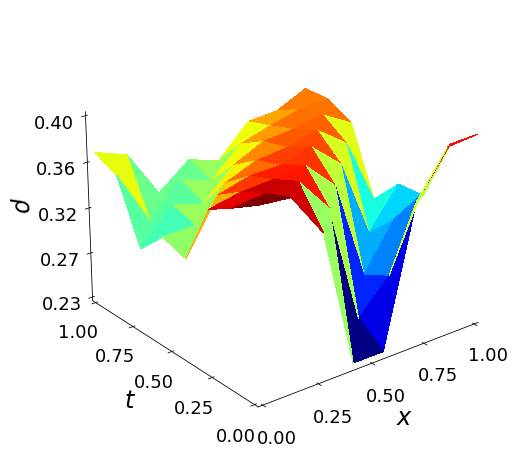

In [5]:
plot_3d(8,1,rho,r"$\rho$",None)

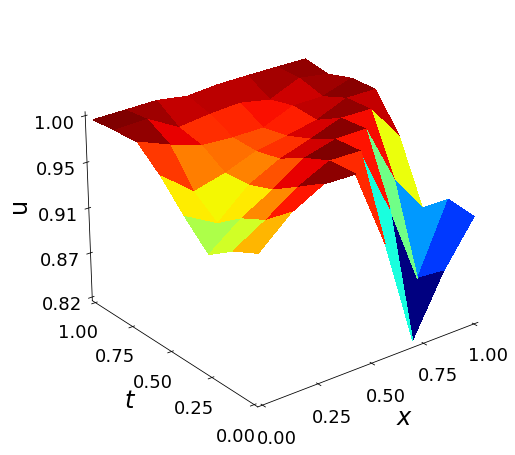

In [6]:
plot_3d(8,1,u,"u",None)

## Smooth Plot

In [7]:
class Actor(nn.Module):
    def __init__(self, state_dim):
        super(Actor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.model(torch.from_numpy(x).float())
        x = torch.tanh(x)
        x = (x + 1) / 2
        return x

In [8]:
actor = Actor(2)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)
truths = []
keys = []
for i in range(8):
    for j in range(8):
        truths.append(u[i, j])
        keys.append(np.array([i, j]) / 8)

truths = torch.tensor(truths, requires_grad=True)
for _ in range(5000):
    preds = torch.reshape(actor(np.array(keys)), (1, len(truths)))
    loss = (truths - preds).abs().mean()
    actor_optimizer.zero_grad()
    loss.backward()
    actor_optimizer.step()

/Users/ninolau/Documents/GitHub/speed_control/utils.py:126: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


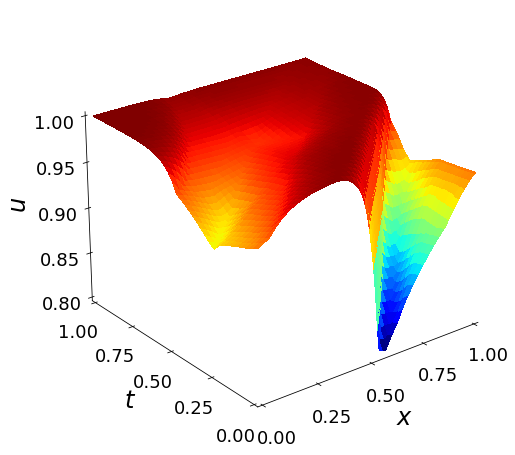

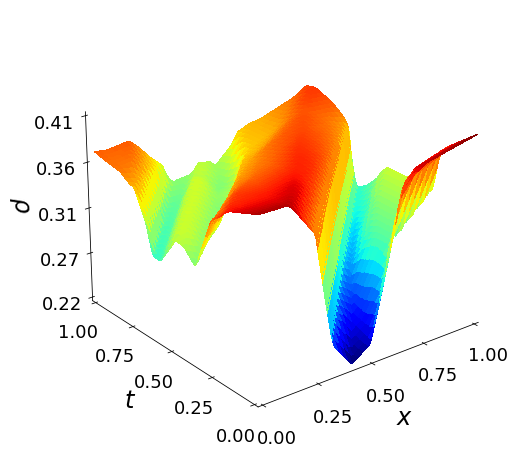

In [9]:
u_plot = np.zeros((n_cell * 16, T * 16))
rho_plot = np.zeros((n_cell * 16, T * 16))
for i in range(n_cell * 16):
    for t in range(T * 16):
        u_plot[i, t] = actor(np.array([i, t]) / n_cell / 16)
        rho_plot[i, t] = rho_network(np.array([i, t]) / n_cell / 16)

plot_3d(n_cell * 16, T_terminal, u_plot, r"$u$", './fig/sep-u.pdf')
plot_3d(n_cell * 16, T_terminal, rho_plot, r"$\rho$", './fig/sep-rho.pdf')